<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In [77]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [78]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2021-12-08 13:03:19--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0s      

2021-12-08 13:03:20 (181 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [79]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [80]:
df.shape

(346, 10)

### Convert to date time object


In [81]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [82]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [83]:
# notice: installing seaborn might takes a few minutes
# !conda install -c anaconda seaborn -y

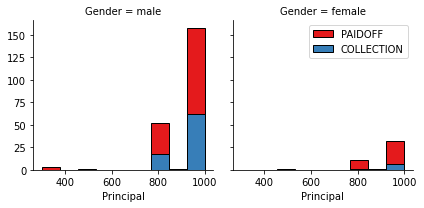

In [84]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

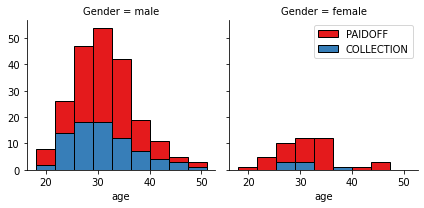

In [85]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


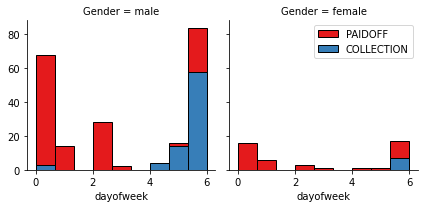

In [86]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [87]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [88]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [89]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [90]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [91]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [92]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [93]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [94]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [95]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.52,  0.92,  2.33, -0.42, -1.21, -0.38,  1.14, -0.87],
       [ 0.52,  0.92,  0.34,  2.38, -1.21,  2.62, -0.88, -0.87],
       [ 0.52, -0.96, -0.65, -0.42, -1.21, -0.38, -0.88,  1.15],
       [ 0.52,  0.92, -0.49,  2.38,  0.83, -0.38, -0.88,  1.15],
       [ 0.52,  0.92, -0.32, -0.42,  0.83, -0.38, -0.88,  1.15]])

# Classification


Use the training set to build an accurate model. Then use the test set to report the accuracy of the model
using the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression


## Train Test Split

In [96]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [97]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [98]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    knn = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat_knn=knn.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat_knn)

    
    std_acc[n-1]=np.std(yhat_knn==y_test)/np.sqrt(yhat_knn.shape[0])

mean_acc

array([0.77, 0.61, 0.77, 0.66, 0.77, 0.73, 0.77, 0.67, 0.71])

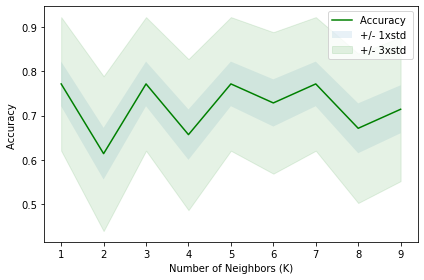

In [99]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [100]:
# Based on on the results of the plot above k=1,3,5 provide best results. k=3 is chosen for the model
k = 3
#Train Model and Predict  
knn = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)

In [101]:
yhat_KNN = knn.predict(X_test)

In [102]:
from sklearn.metrics import f1_score
f1_KNN = f1_score(y_test, yhat_KNN, average='weighted') 
print('F1 score for KNN is ', f1_KNN)

F1 score for KNN is  0.764642375168691


In [103]:
from sklearn.metrics import jaccard_score
jac_KNN = jaccard_score(y_test, yhat_KNN, average='weighted')#pos_label=None)#['COLLECTION', 'PAIDOFF'])
print('Jaccard score for KNN is ', jac_KNN)

Jaccard score for KNN is  0.6506959706959707


# Decision Tree


In [104]:
from sklearn import tree
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

In [105]:
param_grid = {'max_depth': [1,2,3,4,5,6,7,8,9,10], 'min_samples_split': [2,3,4,5],'min_samples_leaf': [2,3,4,5],'max_features':['auto', 'sqrt', 'log2'],'random_state':[0,42]}
grid_DT = GridSearchCV(tree.DecisionTreeClassifier(),param_grid,refit=True)#,verbose=2)
grid_DT.fit(X_train,y_train)
grid_DT.best_params_
# summarize
print('Mean Accuracy: %.3f' % grid_DT.best_score_)
print('Config: %s' % grid_DT.best_params_)

Mean Accuracy: 0.750
Config: {'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 2, 'random_state': 42}


In [106]:
print(grid_DT.best_estimator_)

DecisionTreeClassifier(max_depth=5, max_features='log2', min_samples_leaf=3,
                       random_state=42)


In [107]:
# based on GridSearchCV the best parameters for max depth is 8, max features - auto, min samples leaf - 3, and random state -0

tree_clf = tree.DecisionTreeClassifier(max_depth=8, max_features='auto', min_samples_leaf=3, random_state=0).fit(X_train, y_train)

yhat_DT = tree_clf.predict(X_train)
train_accuracy = balanced_accuracy_score(y_train, yhat_DT)

yhat_test_DT = tree_clf.predict(X_test)
test_accuracy = balanced_accuracy_score(y_test, yhat_test_DT)

print("Train accuracy", train_accuracy)
print("Test accuracy", test_accuracy)

Train accuracy 0.7418300653594772
Test accuracy 0.5535714285714286


In [108]:
f1_DT = f1_score(y_test, yhat_test_DT, average='weighted') 
print('F1 score for Decision Tree model is', f1_DT)

F1 score for Decision Tree model is 0.7142857142857143


In [109]:
jac_DT = jaccard_score(y_test, yhat_test_DT, average='weighted')#pos_label=None)#['COLLECTION', 'PAIDOFF'])
print('Jaccard score for Decision Tree model is', jac_DT)

Jaccard score for Decision Tree model is 0.5909090909090909


In [110]:
Feature.columns

Index(['Principal', 'terms', 'age', 'Gender', 'weekend', 'Bechalor',
       'High School or Below', 'college'],
      dtype='object')

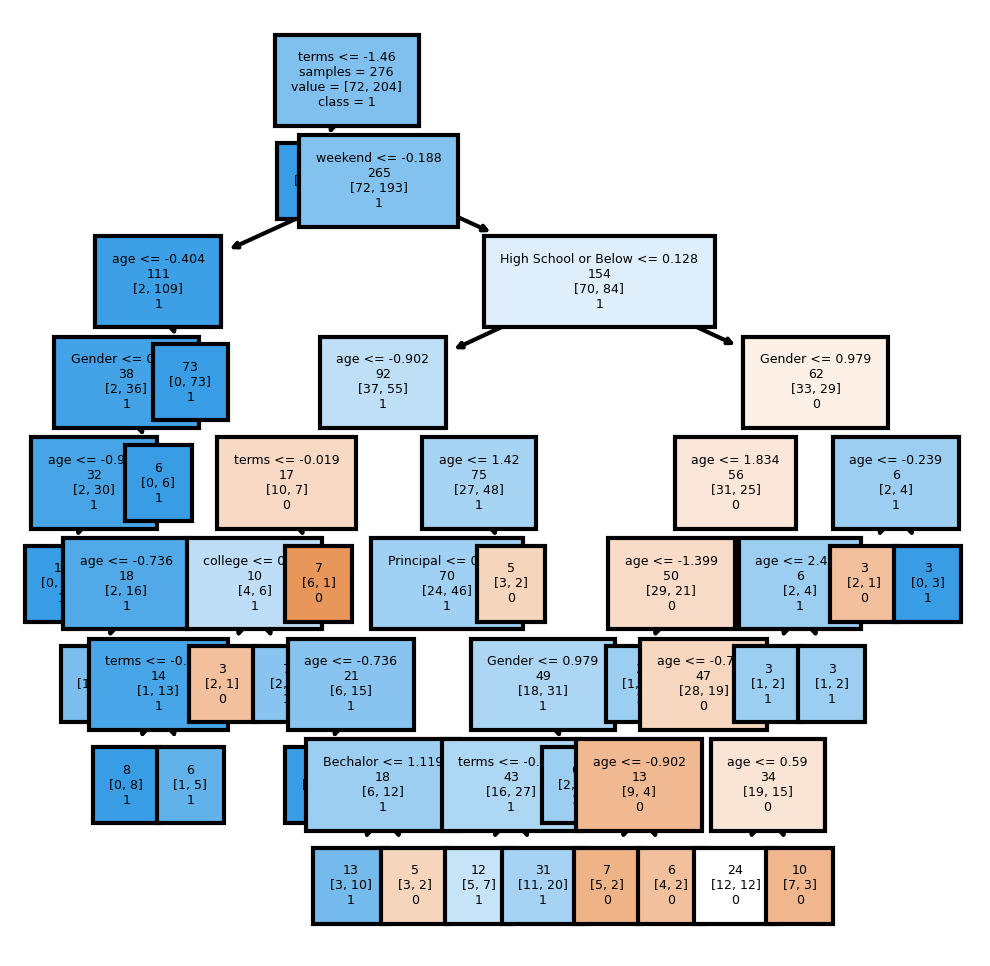

In [111]:
from sklearn.tree import plot_tree

plot = plt.subplots(figsize = (4,4), dpi=300)[0]
plot = plot_tree(tree_clf,
                fontsize=3,
                feature_names = Feature.columns, 
                class_names = ['0','1'], # class_names in ascending numerical order 
                label="root",
                impurity=False,
                filled=True) 
plt.show()

# Support Vector Machine


In [112]:
from sklearn.svm import SVC

param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
grid_SVC = GridSearchCV(SVC(),param_grid,refit=True)#,verbose=2)
grid_SVC.fit(X_train,y_train)
grid_SVC.best_params_
# summarize
print('Mean Accuracy: %.3f' % grid_SVC.best_score_)
print('Config: %s' % grid_SVC.best_params_)

Mean Accuracy: 0.757
Config: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


In [113]:
print(grid_SVC.best_estimator_)

SVC(C=100, gamma=0.01)


In [114]:
kernels = ['Polynomial', 'RBF', 'Sigmoid','Linear']#A function which returns the corresponding SVC model
def getClassifier(ktype):
    if ktype == 0:
        # Polynomial kernel
        return SVC(kernel='poly', degree=8, gamma="auto")
    elif ktype == 1:
        # Radial Basis Function kernal
        return SVC(kernel='rbf', gamma="auto")
    elif ktype == 2:
        # Sigmoid kernel
        return SVC(kernel='sigmoid', gamma="auto")
    elif ktype == 3:
        # Linear kernel
        return SVC(kernel='linear', gamma="auto")

In [115]:
for i in range(4):
    # Separate data into test and training sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)# Train a SVC model using different kernal
    svclassifier = getClassifier(i) 
    svclassifier.fit(X_train, y_train)# Make prediction
    y_pred = svclassifier.predict(X_test)# Evaluate our model
    print("Evaluation:", kernels[i], "kernel")
    print(classification_report(y_test,y_pred))

Evaluation: Polynomial kernel
              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        13
     PAIDOFF       0.81      0.95      0.87        57

    accuracy                           0.77        70
   macro avg       0.40      0.47      0.44        70
weighted avg       0.66      0.77      0.71        70

Evaluation: RBF kernel
              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        16
     PAIDOFF       0.77      1.00      0.87        54

    accuracy                           0.77        70
   macro avg       0.39      0.50      0.44        70
weighted avg       0.60      0.77      0.67        70

Evaluation: Sigmoid kernel
              precision    recall  f1-score   support

  COLLECTION       0.25      0.07      0.11        15
     PAIDOFF       0.79      0.95      0.86        55

    accuracy                           0.76        70
   macro avg       0.52      0.51      0.48     

In [116]:
# based on the grid search and kernel selection 'rbf', c=100 and gamma=0.01 were selected for SVC model

svm = SVC(kernel='rbf', C=100, gamma=0.01)
svm.fit(X_train, y_train) 
yhat_SVM = svm.predict(X_test)

In [117]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 3 13]
 [ 6 48]]


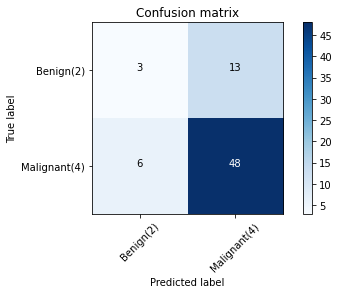

In [118]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat_SVM)#, labels=[2,4])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Benign(2)','Malignant(4)'],normalize= False,  title='Confusion matrix')

In [119]:
f1_SVM = f1_score(y_test, yhat_SVM, average='weighted') 
print('F1 score for SVC is ',f1_SVM)

F1 score for SVC is  0.698832298136646


In [120]:
jac_SVM = jaccard_score(y_test, yhat_SVM, average='weighted')#pos_label=None)#['COLLECTION', 'PAIDOFF'])
print ('Jaccard score for SVC is ', jac_SVM)

Jaccard score for SVC is  0.5838340763713897


# Logistic Regression


In [121]:
from sklearn.linear_model import LogisticRegression

In [122]:
import warnings
warnings.filterwarnings("ignore", category=Warning)

In [123]:
LR = LogisticRegression()
LRparam_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 300, 400, 500, 800, 1000],
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'random_state':[0,42],
    'max_iter': list(range(100,10000,500)),#[100,500,1000,10000],#
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'fit_intercept':['True','False'],
    'multi_class':['auto', 'ovr', 'multinomial']
}
LR_search = GridSearchCV(LR, param_grid=LRparam_grid, refit = True, cv=5)#, verbose = 3

# fitting the model for grid search 
LR_search.fit(X_train , y_train)
LR_search.best_params_
# summarize
print('Mean Accuracy: %.3f' % LR_search.best_score_)
print('Config: %s' % LR_search.best_params_)

Mean Accuracy: 0.746
Config: {'C': 0.1, 'fit_intercept': 'True', 'max_iter': 100, 'multi_class': 'auto', 'penalty': 'l1', 'random_state': 0, 'solver': 'liblinear'}


In [124]:
print(LR_search.best_estimator_)

LogisticRegression(C=0.1, fit_intercept='True', penalty='l1', random_state=0,
                   solver='liblinear')


In [125]:
# best parameters for Logistic Regression were c=0.01, solver='saga', penalty='l1' and max_iter=100
LR = LogisticRegression(C= 0.1, fit_intercept= 'True', max_iter= 100, multi_class= 'auto', penalty= 'l1', random_state= 0, solver= 'liblinear').fit(X_train,y_train) #, penalty='l2', 
LR

LogisticRegression(C=0.1, fit_intercept='True', penalty='l1', random_state=0,
                   solver='liblinear')

In [126]:
yhat_LogReg = LR.predict(X_test)

In [127]:
yhat_prob_LogReg = LR.predict_proba(X_test)

In [128]:
jac_LogReg = jaccard_score(y_test, yhat_LogReg, average='weighted')#,pos_label=2)
print('Jaccard score for Logistic Regression model is ',jac_LogReg)

Jaccard score for Logistic Regression model is  0.5951020408163266


In [129]:
f1_LogReg = f1_score(y_test, yhat_LogReg, average='weighted') 
print('F1 score for Logistic Regression model is ',f1_LogReg)

F1 score for Logistic Regression model is  0.671889400921659


Confusion matrix, without normalization
[[ 0 16]
 [ 0 54]]


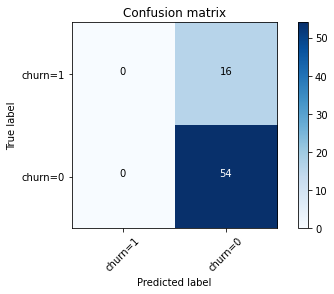

In [130]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat_LogReg)#, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['churn=1','churn=0'],normalize= False,  title='Confusion matrix')

In [131]:
from sklearn.metrics import log_loss
from sklearn import metrics

qry_loss_t = metrics.log_loss(y_test, yhat_prob_LogReg)
print('Logistic Regression LogLoss score is',qry_loss_t)

Logistic Regression LogLoss score is 0.47627668342431206


# Model Evaluation using Test set


First, download and load the test set:


In [132]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-12-08 13:10:33--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-12-08 13:10:34 (88.6 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [133]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [134]:
# pre-processing test data to enable running models

test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
Feature = test_df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(test_df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
X_t = Feature
y_t = test_df['loan_status'].values
X_t = preprocessing.StandardScaler().fit(X_t).transform(X_t)

In [135]:
y_t.shape, X_t.shape

((54,), (54, 8))

In [136]:
# Testing KNN model on test data

yhat_KNN = knn.predict(X_t)

f1_KNN_t = f1_score(y_t, yhat_KNN, average='weighted')
print('KNN F1 score = ',f1_KNN)
jac_KNN_t = jaccard_score(y_t, yhat_KNN, average='weighted')
print('KNN Jaccard score = ',jac_KNN)

KNN F1 score =  0.764642375168691
KNN Jaccard score =  0.6506959706959707


In [137]:
# Testing Decision Tree model on test data

dt_t = tree_clf.predict(X_t)
f1_DT_t = f1_score(y_t, dt_t, average='weighted')
print('Decision Tree Classifier F1 score = ',f1_DT)
jac_DT_t = jaccard_score(y_t, dt_t, average='weighted')
print('Decision Tree Classifier Jaccard score = ',jac_DT_t)

Decision Tree Classifier F1 score =  0.7142857142857143
Decision Tree Classifier Jaccard score =  0.651207729468599


In [138]:
# Testing SVM model on test data

svm_t = svm.predict(X_t)
# print(f1_score(y_t, svm_t, average='weighted'))
# print(jaccard_score(y_t, svm_t, average='weighted'))
f1_SVM_t = f1_score(y_t, svm_t, average='weighted')
print('SVM F1 score = ', f1_SVM_t)
jac_SVM_t = jaccard_score(y_t, svm_t, average='weighted')
print('SVM Jaccard score = ', jac_SVM_t)

SVM F1 score =  0.7552266854592437
SVM Jaccard score =  0.6355875683606775


In [139]:
# Testing LogisticRegression model on test data

lr_t = LR.predict(X_t)
lr_t_prob = LR.predict_proba(X_t)

jac_LogReg_t = jaccard_score(y_t, lr_t, average='weighted')
print('Logistic Regression Jaccard score = ', jac_LogReg_t)

f1_LogReg_t = f1_score(y_t, lr_t, average='weighted') 
print('Logistic Regression F1 score = ', f1_LogReg_t)

log_loss_t_lr = metrics.log_loss(y_t, lr_t_prob)
print('Logistic Regression LogLoss score = ', log_loss_t_lr)

Logistic Regression Jaccard score =  0.5486968449931412
Logistic Regression F1 score =  0.6304176516942475
Logistic Regression LogLoss score =  0.49623966509844425


# Report

Report the accuracy of the built model using different evaluation metrics:


In [140]:
rep_dic = {'Algorithm': ['KNN','Decision Tree','SVM','LogisticRegression'], 'Jaccard':[jac_KNN_t,jac_DT_t, jac_SVM_t, jac_LogReg_t], 'F1-score':[f1_KNN_t,f1_DT_t,f1_SVM_t,f1_LogReg_t], 'LogLoss':['NA','NA','NA',log_loss_t_lr]}

report_df = pd.DataFrame(data=rep_dic, index=None)

report_df

,Algorithm,Jaccard,F1-score,LogLoss
0,KNN,0.494777,0.620252,NA
1,Decision Tree,0.651208,0.777778,NA
2,SVM,0.635588,0.755227,NA
3,LogisticRegression,0.548697,0.630418,0.49624
